# Лабораторная работа №2. Вычислительная математика. Манджиев Улюмджи. Б01-204

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Параметры системы о) из II.10.5.

In [2]:
m = 100 # количество уравнений в системе
a = b = 10

## Переход в матричную запись

In [3]:
A = np.zeros((m, m)) # пустая матрица которую будем заполнять

A[0, 0:3] = [a, 1, 1/b] # первая строка 
A[1, 0:4] = [1, a, 1, 1/b] # вторая строка

for i in range(1, m-2):
    A[i, i-1:i+3] = [1, a, 1, 1/b] # все остальные строки
    
A[m-2, m-3:] = [1, a, 1] #предпоследняя строка
A[m-1, m-2:] = [1, a] #последняя строка


b = np.arange(1, m+1) #вектор правой части

## Методы решения СЛАУ

### Метод Гаусса с вобором главного элемента

In [4]:
def gauss(A, b):
    n = len(b)
    A = A.astype(float)
    b = b.astype(float)
    
    for i in range(n):
        # Выбор главного элемента
        max_row_index = np.argmax(np.abs(A[i:, i])) + i
        A[[i, max_row_index]] = A[[max_row_index, i]]
        b[[i, max_row_index]] = b[[max_row_index, i]]
        
        for j in range(i + 1, n):
            factor = A[j][i] / A[i][i]
            A[j] -= factor * A[i]
            b[j] -= factor * b[i]
    
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (b[i] - np.dot(A[i, i + 1:], x[i + 1:])) / A[i][i]
    
    return x

### Метод LU-разложения

In [5]:
def lu_decomposition(A):
    n = A.shape[0]
    L = np.zeros((n, n))
    U = np.zeros((n, n))

    for i in range(n):
        L[i, i] = 1  # Диагональные элементы L равны 1
        for j in range(i, n):
            U[i, j] = A[i, j] - np.dot(L[i, :i], U[:i, j])  # Заполнение U
        for j in range(i + 1, n):
            L[j, i] = (A[j, i] - np.dot(L[j, :i], U[:i, i])) / U[i, i]  # Заполнение L

    return L, U
    
def forward_substitution(L, b):
    n = L.shape[0]
    y = np.zeros(n)

    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])

    return y

def backward_substitution(U, y):
    n = U.shape[0]
    x = np.zeros(n)

    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i + 1:], x[i + 1:])) / U[i, i]

    return x

### Метод Якоби

In [6]:
def jacobi(A, b, max_iterations=1000):
    n = len(b)
    x = np.zeros(n)
    residuals1 = []
    residuals2 = []
    residuals3 = []

    for k in range(max_iterations):
        x_new = np.zeros(n)
        
        for i in range(n):
            sum_ajxj = sum(A[i][j] * x[j] for j in range(n) if j != i)
            x_new[i] = (b[i] - sum_ajxj) / A[i][i]
            
        # Вычисляем невязки
        residuals1.append(np.linalg.norm(b - np.dot(A, x_new))) # по норме 3 (евклидова)
        residuals2.append(np.linalg.norm(b - np.dot(A, x_new),1)) # по норме 2 ( max(сумма по столбцово))
        residuals3.append(np.linalg.norm(b - np.dot(A, x_new), np.inf)) # по норме 1 ( max(сумма по строчно))
        
        x = x_new
    
    return x, residuals1,residuals2,residuals3

### Метод Зейделя

In [7]:
def seidel(A, b, max_iterations=1000):
    n = len(b)
    x = np.zeros(n)
    residuals1 = []
    residuals2 = []
    residuals3 = []

    for k in range(max_iterations):
        x_new = np.copy(x)

        for i in range(n):
            sum_ajxj = sum(A[i][j] * x_new[j] for j in range(i)) + sum(A[i][j] * x[j] for j in range(i + 1, n))
            x_new[i] = (b[i] - sum_ajxj) / A[i][i]

        # Вычисляем невязки
        residuals1.append(np.linalg.norm(b - np.dot(A, x_new))) # по норме 3 (евклидова)
        residuals2.append(np.linalg.norm(b - np.dot(A, x_new),1)) # по норме 2 ( max(сумма по столбцово))
        residuals3.append(np.linalg.norm(b - np.dot(A, x_new), np.inf)) # по норме 1 ( max(сумма по строчно))

        x = x_new
    
    return x, residuals1,residuals2,residuals3

### Метод верхней релаксации

In [8]:
def over_relaxation(A, b, omega=1.25, max_iterations=1000):
    n = len(b)
    x = np.zeros(n)
    residuals1 = []
    residuals2 = []
    residuals3 = []

    for k in range(max_iterations):
        x_new = np.copy(x)

        for i in range(n):
            sum_ajxj = sum(A[i][j] * x_new[j] for j in range(i)) + sum(A[i][j] * x[j] for j in range(i + 1, n))
            x_new[i] = (1 - omega) * x[i] + (omega * (b[i] - sum_ajxj) / A[i][i])

        # Вычисляем невязки
        residuals1.append(np.linalg.norm(b - np.dot(A, x_new))) # по норме 3 (евклидова)
        residuals2.append(np.linalg.norm(b - np.dot(A, x_new),1)) # по норме 2 ( max(сумма по столбцово))
        residuals3.append(np.linalg.norm(b - np.dot(A, x_new), np.inf)) # по норме 1 ( max(сумма по строчно))

        x = x_new
    
    return x, residuals1,residuals2, residuals3

### Метод градиентного спуска

In [9]:
def gradient_descent(A, b,tol=1e-10, max_iterations=1000):
    n = len(b)
    x = np.zeros(n)

    r = b - np.dot(A, x)
    
    for k in range(max_iterations):
        alpha = np.dot(r, r) / np.dot(r, np.dot(A, r)) # шаг альфа
        x += alpha * r
        r_new = b - np.dot(A, x)
        
        if np.linalg.norm(r_new) < tol:
            break
        
        r = r_new
    
    return x

### Метод минимальных невязок

In [10]:
def minimum_discrepancies(A, b, learning_rate=0.01, num_iterations=1000):
    n = len(b)
    x = np.zeros(n)  

    for k in range(num_iterations):
        
        prediction = A.dot(x)
        error = prediction - b
        gradient = (2/n) * A.T.dot(error)
        x -= learning_rate * gradient

    return x

### Стабилизированный метод бисопряженных градиентов

In [11]:
def bisjoint_gradient(A, b,tol=1e-10, max_iterations=1000):
    n = len(b)
    x = np.zeros(n)
    r = b - np.dot(A, x)
    p = r.copy()
    
    
    for k in range(max_iterations):
        alpha = np.dot(r, r) / np.dot(p, np.dot(A, p))
        x += alpha * p
        r_new = r - alpha * np.dot(A, p)

        if np.linalg.norm(r_new) < tol:
            break
        
        beta = np.dot(r_new, r_new) / np.dot(r, r)
        p = r_new + beta * p
        r = r_new
    
    return x

## Непосредственное решение уравнение Ax=b представленными выше методами

In [12]:
L, U = lu_decomposition(A) 

print("Метод Гаусса:", gauss(A, b))

print('\n')

print("Метод LU:", backward_substitution(U, y = forward_substitution(L, b)))
jacobi_solution, jacobi_residuals1, jacobi_residuals2, jacobi_residuals3= jacobi(A, b)

print('\n')

print("Метод Якоби:", jacobi_solution)
gauss_seidel_solution, gauss_seidel_residuals1,gauss_seidel_residuals2,gauss_seidel_residuals3 = seidel(A, b)

print('\n')

print("Метод Зейделя:", gauss_seidel_solution)
over_relaxation_solution, over_relaxation_residuals1,over_relaxation_residuals2,over_relaxation_residuals3 = over_relaxation(A, b)

print('\n')

print("Метод верхней релаксации:", over_relaxation_solution)
gradient_solution= gradient_descent(A, b)

print('\n')

print("Метод градиентного спуска:", gradient_solution)
least_squares_solution= minimum_discrepancies(A, b)

print('\n')

print("Метод минимальных невязок:", least_squares_solution)
conjugate_gradient_solution = bisjoint_gradient(A, b)

print('\n')

print("Стабилизированный метод бисопряженных градиентов:", conjugate_gradient_solution)

Метод Гаусса: [0.08114062 0.16393717 0.24656645 0.32921263 0.4118571  0.49450174
 0.57714637 0.659791   0.74243563 0.82508025 0.90772488 0.99036951
 1.07301414 1.15565877 1.23830339 1.32094802 1.40359265 1.48623728
 1.56888191 1.65152654 1.73417116 1.81681579 1.89946042 1.98210505
 2.06474968 2.1473943  2.23003893 2.31268356 2.39532819 2.47797282
 2.56061744 2.64326207 2.7259067  2.80855133 2.89119596 2.97384058
 3.05648521 3.13912984 3.22177447 3.3044191  3.38706373 3.46970835
 3.55235298 3.63499761 3.71764224 3.80028687 3.88293149 3.96557612
 4.04822075 4.13086538 4.21351001 4.29615463 4.37879926 4.46144389
 4.54408852 4.62673315 4.70937777 4.7920224  4.87466703 4.95731166
 5.03995629 5.12260092 5.20524554 5.28789017 5.3705348  5.45317943
 5.53582406 5.61846868 5.70111331 5.78375794 5.86640257 5.9490472
 6.03169182 6.11433645 6.19698108 6.27962571 6.36227034 6.44491496
 6.52755959 6.61020422 6.69284885 6.77549348 6.85813811 6.94078273
 7.02342736 7.10607199 7.18871662 7.27136125 7.35

## Графики убывания невязки для методов Якоби,Гаусса и верхней релаксации в логарифмическом масштабе

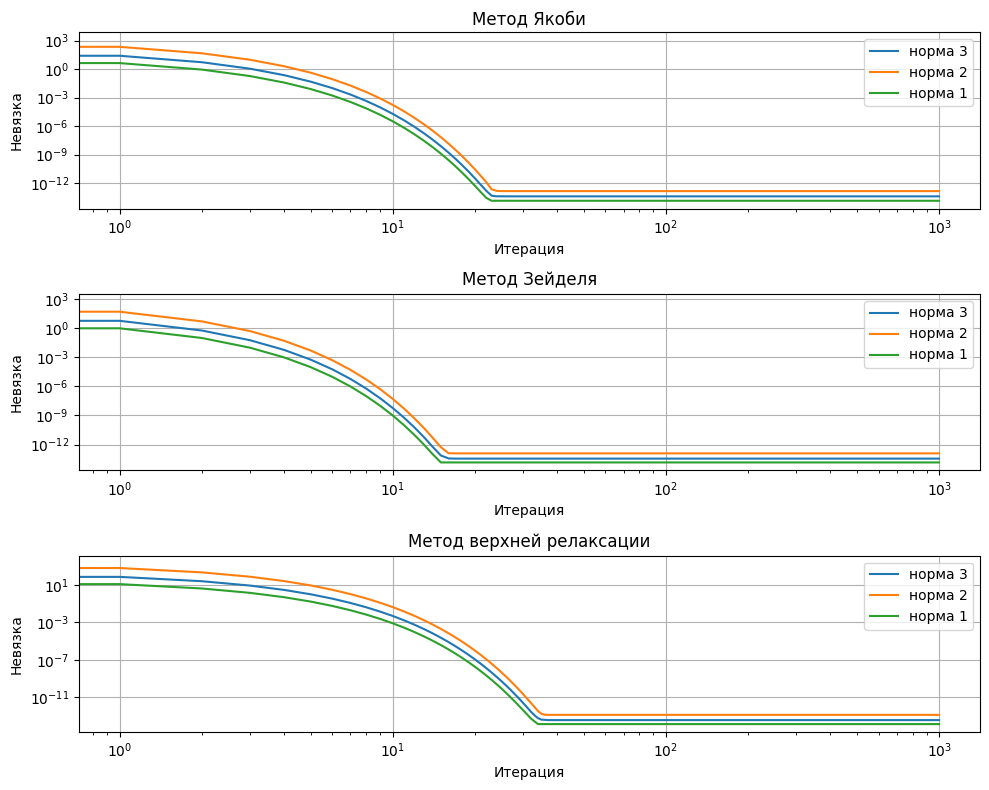

In [13]:
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(jacobi_residuals1,label = 'норма 3')
plt.plot(jacobi_residuals2,label = 'норма 2')
plt.plot(jacobi_residuals3,label = 'норма 1')
plt.yscale('log')
plt.xscale('log')
plt.title('Метод Якоби')
plt.xlabel('Итерация')
plt.ylabel('Невязка')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(gauss_seidel_residuals1,label = 'норма 3')
plt.plot(gauss_seidel_residuals2,label = 'норма 2')
plt.plot(gauss_seidel_residuals3,label = 'норма 1')
plt.yscale('log')
plt.xscale('log')
plt.title('Метод Зейделя')
plt.xlabel('Итерация')
plt.ylabel('Невязка')
plt.grid()
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(over_relaxation_residuals1,label = 'норма 3')
plt.plot(over_relaxation_residuals2,label = 'норма 2')
plt.plot(over_relaxation_residuals3,label = 'норма 1')
plt.yscale('log')
plt.xscale('log')
plt.title('Метод верхней релаксации')
plt.xlabel('Итерация')
plt.ylabel('Невязка')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()